# querying Aris from CasJobs : Count objects in low-level HTM cells
Useful links for plotting :
* https://coolum001.github.io/geopandasdisplay.html

Prerequisites:

* use Geo image
* pip install healpy

In [1]:
import SciServer.CasJobs as cj
from datetime import datetime
import pandas
import geopandas as gpd
from shapely import wkt
import cartopy.crs as ccrs
import matplotlib.pyplot as plt
import healpy

In [2]:
LSST="LSST_aris"
# code for perfect(unit?) sphere
SRID=104001

In [6]:
def plotPRColored(_gdf, column=None,crs=None,figsize=[12,9],plot_title="", colorbar_title=None,colormap='copper_r'):
    """
    plot geopandas geo-dataframe colored by one of its columns.
    From https://stackoverflow.com/questions/54236083/geopandas-reduce-legend-size-and-remove-white-space-below-map find out 
    how to ensure the colorbar legend is same height as the plot
    """
    import matplotlib.pyplot as plt
    
    if crs is not None:
        gdf=_gdf.to_crs({"init":"epsg:{crs}".format(crs=crs)})
        plot_title=plot_title+" ({crs})".format(crs=crs)
    else:
        gdf=_gdf
        
    if column is None:
        ax = gdf.plot(figsize=figsize)
    
    else:
        if colorbar_title is None:
            colorbar_title=column
        ax = gdf.plot(column=column, cmap=colormap, \
                        figsize=figsize,vmin=min(gdf[column]), vmax=max(gdf[column]))
        #ax.grid() 
        # colorbar will be created by ...
        fig = ax.get_figure()
        # add colorbar axes to the figure
        # here, need trial-and-error to get [l,b,w,h] right
        # l:left, b:bottom, w:width, h:height; in normalized unit (0-1)
        cbax = fig.add_axes([0.95, 0.3, 0.03, 0.39])   
        cbax.set_title(colorbar_title)

        sm = plt.cm.ScalarMappable(cmap=colormap, \
                        norm=plt.Normalize(vmin=min(gdf[column]), vmax=max(gdf[column])))
        # at this stage, 
        # 'cbax' is just a blank axes, with un needed labels on x and y axes

        # blank-out the array of the scalar mappable 'sm'
        sm._A = []
        # draw colorbar into 'cbax'
        fig.colorbar(sm, cax=cbax, format="%d")

    # dont use: plt.tight_layout()
    ax.set_title(plot_title)
    return ax

## count Object rows in HTM triangles at level LEVEL
Various different version of table used

In [117]:
%%time
#
# use temptable #a iso defining it inside CTE, as otherwise it will be executed multiple times in the union
#
def queryHTMCounts(object_table,level):
    print("[",datetime.now(),"] table:",object_table,", level:",level)
    pow=20-level
    sql="""
with a as (
select htmid/power(4,{pow}) as htmid_L, count(*) as num
  from m_object_cci
 group by  htmid/power(4,{pow}) 
)
select a.htmid_L,a.num
,      c.i, concat(c.ra,' ',c.dec) as pt 
into #pts
  from a  cross apply htmid.GetCorners(a.htmid_L) c
;

with ptsExt as (  -- need to close the polygon
select * from #pts
union
select htmid_L,num,3,pt
  from #pts 
 where i=0
),
poly as (
select htmid_L,max(num) as num, string_agg(i,'') as orientation
,      geography::STPolyFromText(concat('POLYGON((',STRING_AGG(pt,',') within group (order by i),'))'),104001) as triangle
from ptsExt 
group by htmid_L
)
select p.* , cn.ra as cen_ra, cn.dec as cen_dec, p.triangle.STArea() as area
  from poly p cross apply htmid.GetCenter(p.htmid_L) cn
order by htmid_L

--drop table #pts 

    """.format(pow=20-level,object_table=object_table)
    return cj.executeQuery(sql,LSST)

CPU times: user 0 ns, sys: 24 µs, total: 24 µs
Wall time: 40.8 µs


In [118]:
%time htm5_cci=queryHTMCounts('m_object_cci',5)
# %time htm5_cli=queryHTMCounts('m_object_cli',5)
# %time htm5_page=queryHTMCounts('m_object_page',5)

[ 2020-01-20 17:47:32.920747 ] table: m_object_cci , level: 5
CPU times: user 144 ms, sys: 20.1 ms, total: 164 ms
Wall time: 13.5 s


In [5]:
# %time htm5_dp_htmid=queryHTMCounts('objectdp_htmid',5)

[ 2020-01-20 13:19:18.752975 ] table: objectdp_htmid , level: 5
CPU times: user 90.4 ms, sys: 18.9 ms, total: 109 ms
Wall time: 10.2 s


# Plotting

In [133]:
ghtm5=gpd.GeoDataFrame(htm5_cci,geometry=htm5_cci['triangle'].apply(wkt.loads))

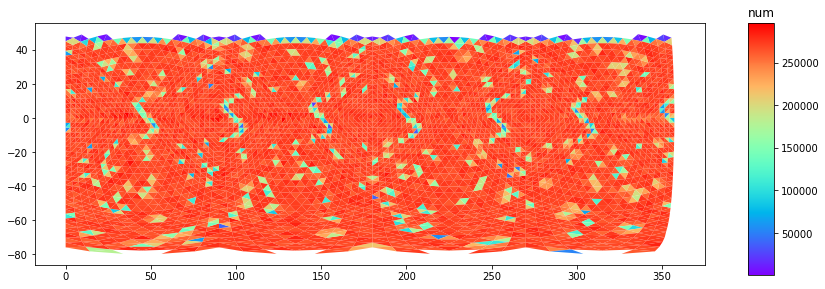

In [134]:
ghtm5['ar']=ghtm5.area

ix=ghtm5['ar']<20   # filter out wrongly transformed triangles

ax=plotPRColored(ghtm5[ix],column='num',colormap='rainbow')


# plot using Mollweide projection
geopandas does not support proper coordinate transformation for mollweide it seems.


# Use centers only
Faster for visualizations, though not as acurate.


In [13]:
%%time

def queryHTMCenters(object_table,level):
    print("[",datetime.now(),"] table:",object_table,", level:",level)
    pow=20-level
    sql="""
with a as (
select htmid/power(4,{pow}) as htmid_L, count(*) as num
  from m_object_cci
 group by  htmid/power(4,{pow}) 
)
select a.htmid_L,a.num, c.ra,c.dec 
  from a cross apply htmid.GetCenter(a.htmid_L) c
order by htmid_L
    """.format(pow=20-level,object_table=object_table)
    return cj.executeQuery(sql,LSST)

CPU times: user 0 ns, sys: 24 µs, total: 24 µs
Wall time: 64.4 µs


In [185]:
%time centers_cci=queryHTMCenters('m_object_cci',7)

[ 2020-01-20 18:36:29.873985 ] table: m_object_cci , level: 7
CPU times: user 996 ms, sys: 161 ms, total: 1.16 s
Wall time: 12.6 s


/home/idies/miniconda3/lib/python3.6/site-packages/matplotlib/projections/geo.py:421: RuntimeWarning: invalid value encountered in arcsin
  theta = np.arcsin(y / np.sqrt(2))


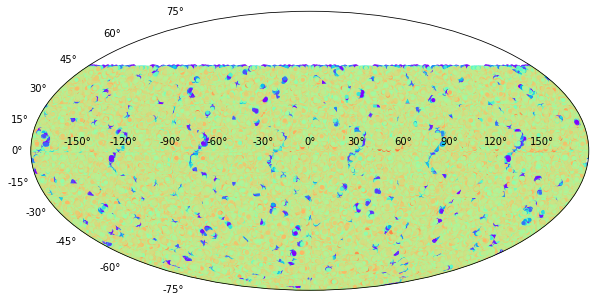

In [199]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='mollweide')
lon=-np.deg2rad(centers_cci['ra'])% (2 * np.pi) - np.pi
lat=np.deg2rad(centers_cci['dec'])
im = ax.scatter(lon,lat,c=centers_cci['num'],s=10, cmap=plt.cm.rainbow)

# use healpix
If we had a HEALPix column, we could do the same kinds of counts using that pixelization. Advantage is that there are libraries to plot the results nicely. For now instead I will use finer sampling of htm grid. Then use pandas groupby to calculate mean of these in larger HEALPix cells and plot those.

In [137]:
%time centers_cci_7=queryHTMCenters('m_object_cci',7)

[ 2020-01-20 18:05:50.526603 ] table: m_object_cci , level: 7
CPU times: user 918 ms, sys: 109 ms, total: 1.03 s
Wall time: 12 s


In [179]:
NSIDE=2**5
THETA=np.deg2rad(90-centers_cci_7['dec'])
PHI=np.deg2rad(centers_cci_7['ra'])
centers_cci_7['healpix']=healpy.pixelfunc.ang2pix(NSIDE, THETA, PHI, nest=False, lonlat=False)

In [181]:
gr=centers_cci_7[['healpix','num']].groupby(['healpix']).agg('mean')

In [182]:
hpmap=np.full(healpy.nside2npix(NSIDE), healpy.UNSEEN)
hpmap[gr.index]=gr['num']

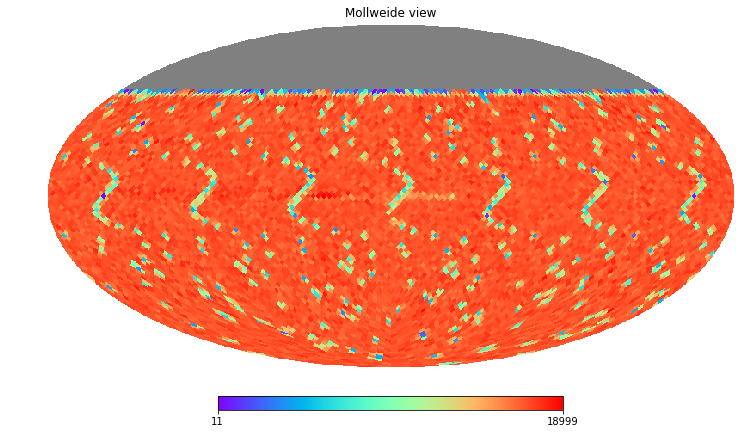

In [200]:
fig = plt.figure(figsize=(10,8))
ax = fig.add_subplot(111, projection='mollweide')
ax.grid()
healpy.mollview(hpmap,cmap='rainbow',badcolor='grey',fig=1)